In [39]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from shapely.geometry import shape
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

In [7]:
# read csv
data = pd.read_csv('data/merged_data.csv')
epa_data = data[['CensusTract','Year','County','Total Cancer Risk (per million)']]

# remove rows with NaN values
epa_data = epa_data.dropna()
#display(epa_data)


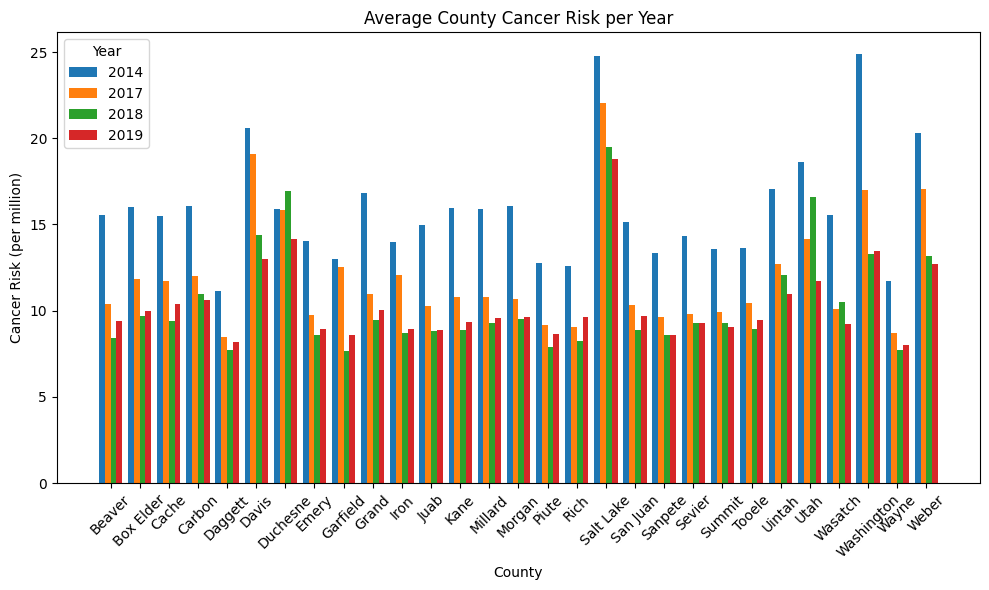

In [8]:
''' “The EPA will generally presume that if the risk to that individual [the Maximum Individual Risk] 
 is no higher than approximately 1 in 10 thousand (100 in 1 million), that risk level is considered acceptable 
 and EPA then considers the other health and risk factors to complete an overall judgment on acceptability.”'''
 # https://www.epa.gov/AirToxScreen/airtoxscreen-frequent-questions
 
#get county average cancer risk
county_avg = epa_data.groupby(['County','Year'])['Total Cancer Risk (per million)'].mean().reset_index()

# Pivot the DataFrame to have years as columns
pivot_df = county_avg.pivot(index='County', columns='Year', values='Total Cancer Risk (per million)')
#display(pivot_df)

# Plotting
bar_width = 0.2
index = np.arange(len(pivot_df.index))
fig, ax = plt.subplots(figsize=(10, 6))
bar_2014 = ax.bar(index - 3 * bar_width / 2, pivot_df[2014], bar_width, label='2014')
bar_2017 = ax.bar(index - bar_width / 2, pivot_df[2017], bar_width, label='2017')
bar_2018 = ax.bar(index + bar_width / 2, pivot_df[2018], bar_width, label='2018')
bar_2019 = ax.bar(index + 3 * bar_width / 2, pivot_df[2019], bar_width, label='2019')

ax.set_title('Average County Cancer Risk per Year')
ax.set_xlabel('County')
ax.set_ylabel('Cancer Risk (per million)')
ax.set_xticks(index)
ax.set_xticklabels(pivot_df.index)
ax.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/home/codespace/.python/current/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_6324/4190612958.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  geo_merged['Risk Quartile'].filln

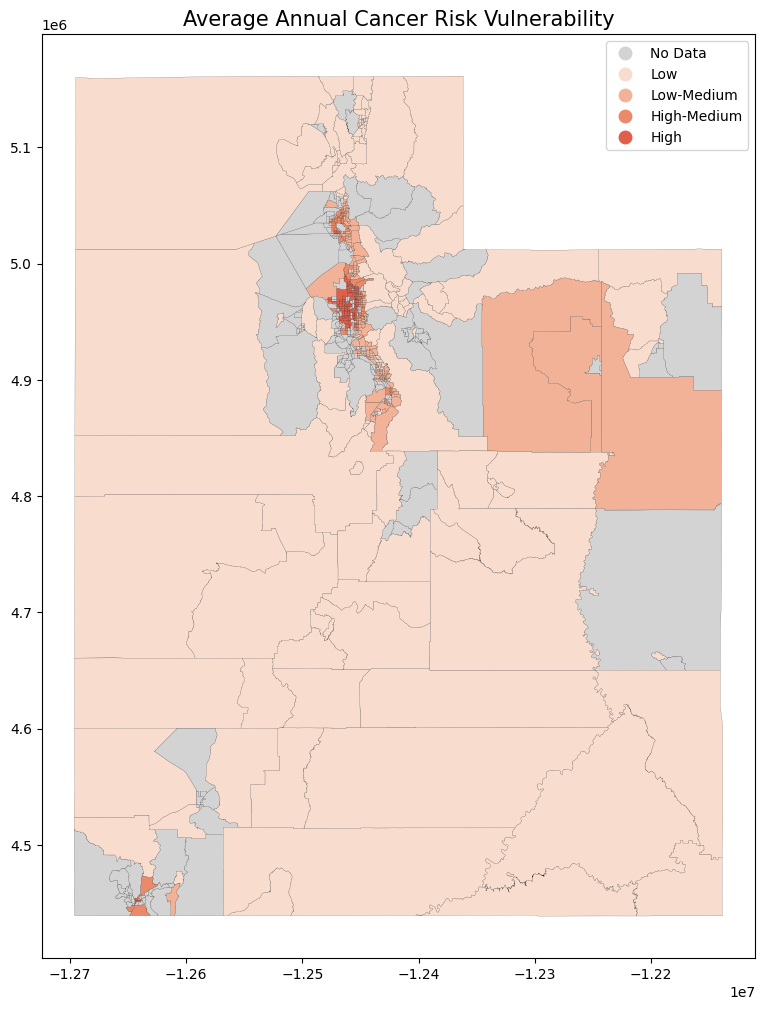

In [62]:
# https://opendata.gis.utah.gov/datasets/utah-census-tracts-2020/about
# 2019 map

# Load the GeoJSON file
geojson = gpd.read_file('data/CensusTracts2020.geojson')
geojson = geojson.rename(columns={'GEOID20':'CensusTract'})

# get average cancer risk for all years
epa_avg = epa_data.groupby(['CensusTract', 'County'])['Total Cancer Risk (per million)'].mean().reset_index()
epa_avg.rename(columns={'Total Cancer Risk (per million)': 'Average Annual Cancer Risk (per million)'}, inplace=True)

# Ensure the GEOID column is the same type in both dataframes, typically a string
geojson['CensusTract'] = geojson['CensusTract'].astype(str)
epa_avg['CensusTract'] = epa_avg['CensusTract'].astype(str)

# Merge the data on the GEOID column
geo_merged = geojson.merge(epa_avg, on='CensusTract', how='left')

# Remove NaN values
geo_merged = geo_merged.fillna(0)

# Convert Total Cancer Risk to int
geo_merged['Average Annual Cancer Risk (per million)'] = geo_merged['Average Annual Cancer Risk (per million)'].astype(int)

# Filter out zero values and create quartiles from the non-zero values
non_zero_data = geo_merged[geo_merged['Average Annual Cancer Risk (per million)'] > 0]
non_zero_data['Risk Quartile'] = pd.qcut(non_zero_data['Average Annual Cancer Risk (per million)'], 4, labels=['Low', 'Low-Medium', 'High-Medium', 'High'])

# Prepare the categorical column with a new category 'Zero'
categories = ['No Data', 'Low', 'Low-Medium', 'High-Medium', 'High']
geo_merged['Risk Quartile'] = pd.Categorical(geo_merged['CensusTract'].map(non_zero_data.set_index('CensusTract')['Risk Quartile']), categories=categories, ordered=True)

# Set zero values' quartile to 'No Data'
geo_merged['Risk Quartile'].fillna('No Data', inplace=True)

# Create a custom colormap
colors = ['Lightgray', '#f8dcce', '#f2b297', '#ea8a6a', '#e15e4a']  # Colors from light red to dark red, gray for zero
cmap = ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5], cmap.N)

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))
geo_merged.plot(column='Risk Quartile', cmap=cmap, norm=norm, linewidth=0.1, ax=ax, edgecolor='0', legend=True, legend_kwds={'labels': ['No Data', 'Low', 'Low-Medium', 'High-Medium', 'High']})

ax.set_title('Average Annual Cancer Risk Vulnerability', fontsize=15)
plt.show()